In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

cuda = torch.device('cuda') 
torch.set_default_tensor_type('torch.cuda.FloatTensor')

torch.cuda.is_available()

True

In [2]:
dtype = torch.cuda.FloatTensor
dtype_long = torch.cuda.LongTensor

#bilinear interpolation of image im at points p
def bilinear(embed, p):
        old_shape = embed.shape
        embed = embed.permute(2, 0, 1).reshape(1, old_shape[2], old_shape[0], old_shape[1])
        #print(embed.shape)
        dtype_long = torch.cuda.LongTensor
        dtype = torch.cuda.FloatTensor
        size = embed.shape
        p = p.clone()
        p[:,0] = p[:,0] * (size[2]-1)
        p[:,1] = p[:,1] * (size[3]-1)
      
        x0 = torch.floor(p[:,0]).type(dtype_long)
        x1 = x0 + 1
        y0 = torch.floor(p[:,1]).type(dtype_long)
        y1 = y0 + 1

        x0 = torch.clamp(x0, 0, size[2]-1)
        x1 = torch.clamp(x1, 0, size[2]-1)
        y0 = torch.clamp(y0, 0, size[3]-1)
        y1 = torch.clamp(y1, 0, size[3]-1)

        embed00 = embed[0,:,x0,y0].permute(1, 0)
        embed01 = embed[0,:,x0,y1].permute(1, 0)
        embed10 = embed[0,:,x1,y0].permute(1, 0)
        embed11 = embed[0,:,x1,y1].permute(1, 0)

        dx0 = (p - torch.stack((x0, y0)).t().type(dtype))
        dx1 = (torch.stack((x1, y1)).t().type(dtype) - p)

        wa = (dx1[:,0] * dx1[:,1]).repeat(size[1], 1).t()
        wb = (dx1[:,0] * dx0[:,1]).repeat(size[1], 1).t()
        wc = (dx0[:,0] * dx1[:,1]).repeat(size[1], 1).t()
        wd = (dx0[:,0] * dx0[:,1]).repeat(size[1], 1).t()
        
        return wa * embed00 + wb * embed01 + wc * embed10 + wd * embed11

#uniformly distributed N dimensional pseudorandom numbers
def WeylPhi(i, N, seed = 0.5):
    def phi(d, x = 2.0): 
        for i in range(10): 
            x = pow(1+x,1/(d+1)) 
        return x
    c = (1/phi(N))**torch.arange(1, N+1, device=cuda)
    return torch.fmod(seed + torch.outer(i, c), 1)


c:\Users\micha\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


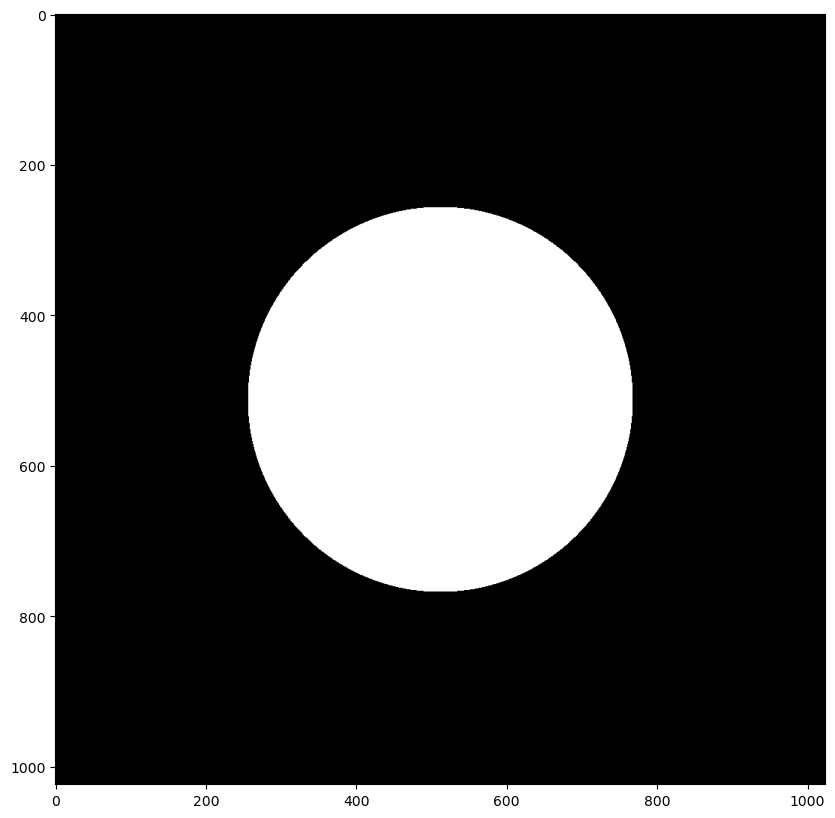

In [3]:
Nimg = 1024

#add a circle
x = torch.arange(0, Nimg, device=cuda)
y = torch.arange(0, Nimg, device=cuda)
x, y = torch.meshgrid(x, y)
target_im = torch.sqrt((x-Nimg/2)**2 + (y-Nimg/2)**2) < Nimg/4
target_im = target_im.view(Nimg, Nimg, 1).type(dtype).repeat(1, 1, 3)

Ntarget = 32
train_im = torch.randn(Ntarget, Ntarget, device=cuda)

plt.figure(figsize=(10,10))
plt.imshow(target_im.cpu().numpy(), cmap='gray')
plt.show()


C:\Users\micha\AppData\Local\Temp\ipykernel_11780\1428803153.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(filename)


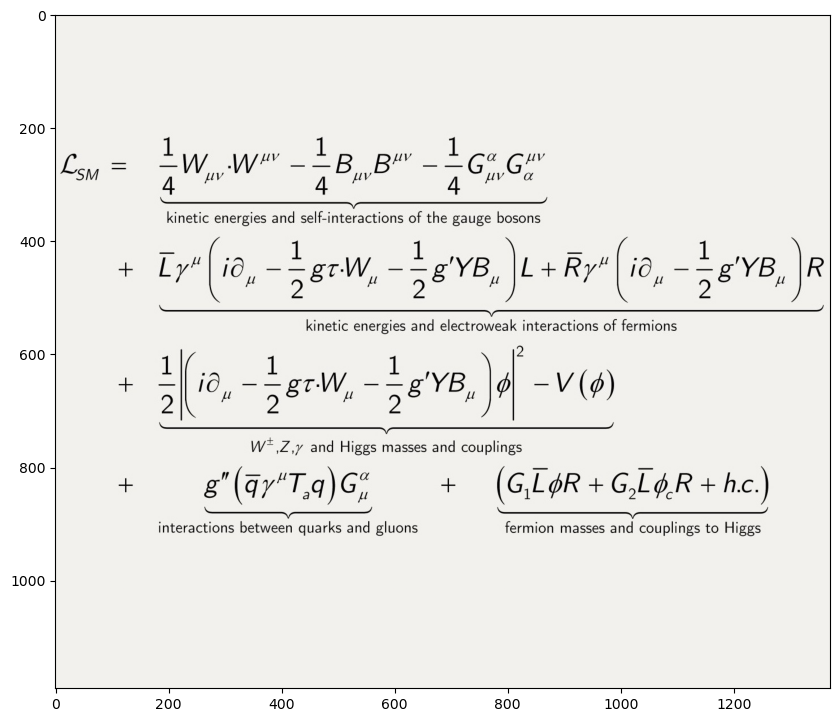

In [146]:
#load a png image from the hard drive

def load_png(filename):
    import imageio
    im = imageio.imread(filename)
    im = im[:,:,0:3]
    im = torch.from_numpy(im).type(dtype)
    return im

target_im = load_png('D:/sm.png')

#normalize the image
target_im = target_im / torch.max(target_im)

plt.figure(figsize=(10,10))
plt.imshow(target_im.cpu().numpy(), cmap='gray')
plt.show()


In [ ]:
#load video from the hard drive 4D tensor (frames, height, width, channels)
def load_video(filename):
    import imageio
    vid = imageio.get_reader(filename,  'ffmpeg')
    Nframes = vid.get_length()
    im = vid.get_data(0)
    im = im[:,:,0:3]
    im = torch.from_numpy(im).type(dtype)
    vid_im = torch.zeros(Nframes, im.shape[0], im.shape[1], im.shape[2], device=cuda)
    for i in range(Nframes):
        im = vid.get_data(i)
        im = im[:,:,0:3]
        im = torch.from_numpy(im).type(dtype)
        vid_im[i] = im
    return vid_im

In [73]:
#reconstruction model for the image
#take a image with embeddings does a bilinear interpolation and then does a few nonlinearities
class ReconstructionModel(nn.Module):
    def __init__(self, Nimg, Nembed, Nnn = 16):
        super(ReconstructionModel, self).__init__()
        self.Nimg = Nimg
        self.Nembed = Nembed
        self.Nnn = Nnn
        self.Nout = 3
        self.Nin = 4 * Nembed
        self.omega = 3.0
        #image with embeddings
        self.embed0 = nn.Parameter(torch.randn(1, Nembed, Nimg, Nimg, device=cuda))
        self.embed1 = nn.Parameter(torch.randn(1, Nembed, Nimg, Nimg, device=cuda))
        self.embed2 = nn.Parameter(torch.randn(1, Nembed, Nimg, Nimg, device=cuda))
        self.embed3 = nn.Parameter(torch.randn(1, Nembed, Nimg, Nimg, device=cuda))
        #nn per each embedding pixel
        self.nn = nn.Sequential(
            nn.Linear(self.Nin, self.Nin),
            nn.Linear(self.Nin, self.Nin),
            nn.Linear(self.Nin, self.Nin),
            nn.Linear(self.Nin, self.Nout),
        )

    def siren(self, x):
        #sinusoidal layer
        x = torch.sin(self.omega * self.nn[0](x))
        #mish layer
        x = torch.sin(self.nn[1](x))
        #mish layer
        x = torch.sin(self.nn[2](x))
        #final layer
        x = self.nn[3](x)

        return x

    def bilinear_smooth(self, embed, p, delta = 0):
        dtype_long = torch.cuda.LongTensor
        dtype = torch.cuda.FloatTensor
        size = embed.shape
        p = p.clone()
        p[:,0] = p[:,0] * (size[2]-2)
        p[:,1] = p[:,1] * (size[3]-2)
        p = p + delta
        x0 = torch.floor(p[:,0]).type(dtype_long)
        x1 = x0 + 1
        y0 = torch.floor(p[:,1]).type(dtype_long)
        y1 = y0 + 1

        x0 = torch.clamp(x0, 0, size[2]-1)
        x1 = torch.clamp(x1, 0, size[2]-1)
        y0 = torch.clamp(y0, 0, size[3]-1)
        y1 = torch.clamp(y1, 0, size[3]-1)

        embed00 = embed[0,:,x0,y0].permute(1, 0)
        embed01 = embed[0,:,x0,y1].permute(1, 0)
        embed10 = embed[0,:,x1,y0].permute(1, 0)
        embed11 = embed[0,:,x1,y1].permute(1, 0)

        def smoothstep(x):
            return 3 * x**2 - 2 * x**3

        dx0 = smoothstep(p - torch.stack((x0, y0)).t().type(dtype))
        dx1 = smoothstep(torch.stack((x1, y1)).t().type(dtype) - p)

        wa = (dx1[:,0] * dx1[:,1]).repeat(self.Nembed, 1).t()
        wb = (dx1[:,0] * dx0[:,1]).repeat(self.Nembed, 1).t()
        wc = (dx0[:,0] * dx1[:,1]).repeat(self.Nembed, 1).t()
        wd = (dx0[:,0] * dx0[:,1]).repeat(self.Nembed, 1).t()
        
        return wa * embed00 + wb * embed01 + wc * embed10 + wd * embed11

    def forward(self, p):
        embed0 = self.bilinear_smooth(self.embed0, p)
        embed1 = self.bilinear_smooth(self.embed1, p) #add offset
        embed2 = self.bilinear_smooth(self.embed2, p, delta=0.5) #add offset
        embed3 = self.bilinear_smooth(self.embed3, p, delta=0.5) #add offset
        return self.siren(torch.cat((embed0, embed1, embed2, embed3), dim=1)).view(-1, 3)

#optimize reconstruction model
def optimize_reconstruction(train_im, model = None, Nimg = 32, Nemb = 8, batch_size = 8168, lr = 0.01, num_iter = 1000):
    if model is None:
        model = ReconstructionModel(Nimg, Nemb).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_iter):
        optimizer.zero_grad()
        p = WeylPhi(torch.arange(0, batch_size, device=cuda), 2, torch.rand(1, device=cuda))
        loss = torch.mean((model(p) - bilinear(target_im, p))**2)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('iteration: ', i, ' loss: ', loss.item())
    return model


#optimize the image to match the target image
def optimize(train_im, target_im, batch_size = 4096, lr = 0.01, num_iter = 1000):
    train_im.requires_grad = True
    optimizer = torch.optim.Adam([train_im], lr=lr)
    for i in range(num_iter):
        optimizer.zero_grad()
        p = WeylPhi(torch.arange(0, batch_size, device=cuda), 2, torch.rand(1, device=cuda))
        loss = torch.mean((bilinear(train_im, p) - bilinear(target_im, p))**2)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('iteration: ', i, ' loss: ', loss.item())
    return train_im

iteration:  0  loss:  0.8653564453125
iteration:  100  loss:  0.01839722879230976
iteration:  200  loss:  0.014633686281740665
iteration:  300  loss:  0.013307584449648857
iteration:  400  loss:  0.010577438399195671
iteration:  500  loss:  0.00803800392895937
iteration:  600  loss:  0.008323918096721172
iteration:  700  loss:  0.007357681170105934
iteration:  800  loss:  0.006828138139098883
iteration:  900  loss:  0.006244680378586054
iteration:  1000  loss:  0.00534990057349205
iteration:  1100  loss:  0.004579395521432161
iteration:  1200  loss:  0.003961433656513691
iteration:  1300  loss:  0.0036699401680380106
iteration:  1400  loss:  0.005863278638571501
iteration:  1500  loss:  0.004914204124361277
iteration:  1600  loss:  0.004627741873264313
iteration:  1700  loss:  0.004034207668155432
iteration:  1800  loss:  0.004265714902430773
iteration:  1900  loss:  0.0035268941428512335


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


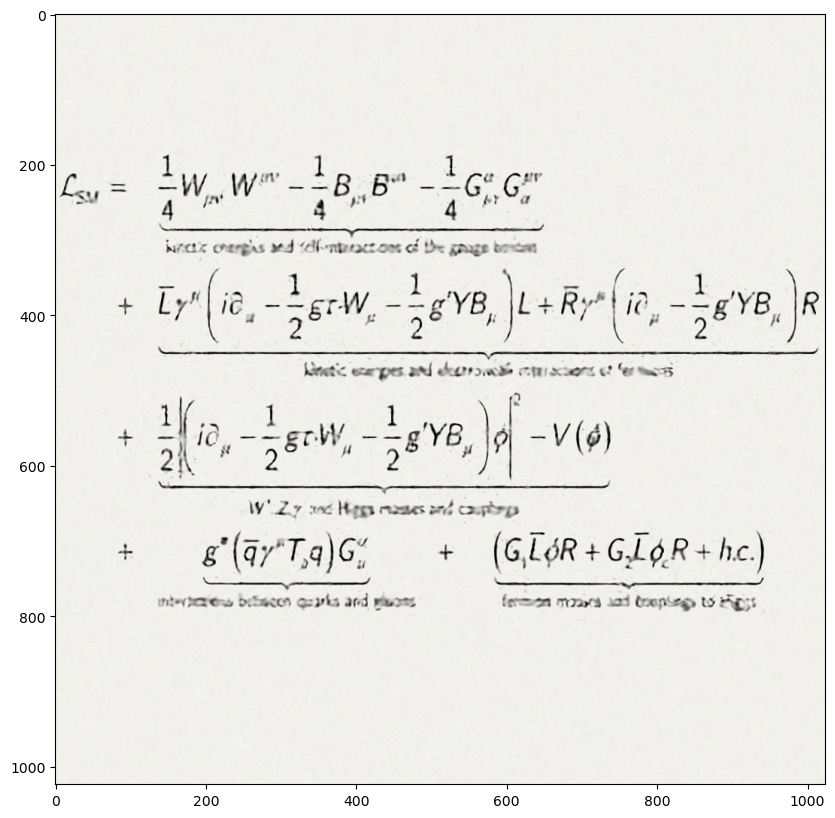

In [147]:
#optimize reconstruction model
model = optimize_reconstruction(target_im, Nimg = 4*16, Nemb = 4, lr = 0.01, num_iter = 2000, batch_size = 10000)

#plot the reconstructed image
Nrecon = 1024
x = torch.linspace(0, 1, Nrecon, device=cuda)
y = torch.linspace(0, 1, Nrecon, device=cuda)
x, y = torch.meshgrid(x, y)
p = torch.stack((x, y), dim=2).view(-1, 2)
reconstructed_im = model(p).view(Nrecon, Nrecon, 3).cpu().detach().numpy()

plt.figure(figsize=(10,10))
plt.imshow(reconstructed_im, cmap='gray')
plt.show()

In [153]:
#optimize reconstruction model
model = optimize_reconstruction(target_im, model = model, lr = 0.001, num_iter = 10000, batch_size = 32768*8)

iteration:  0  loss:  0.0002576351398602128
iteration:  100  loss:  0.00025139289209619164
iteration:  200  loss:  0.0002341219806112349
iteration:  300  loss:  0.00022158950741868466
iteration:  400  loss:  0.0002551020006649196
iteration:  500  loss:  0.0002503820869605988
iteration:  600  loss:  0.00024353600747417659
iteration:  700  loss:  0.0002446509897708893
iteration:  800  loss:  0.00023124103609006852
iteration:  900  loss:  0.00023267748474609107
iteration:  1000  loss:  0.00023879852960817516
iteration:  1100  loss:  0.0002410734596196562
iteration:  1200  loss:  0.0002475715009495616


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


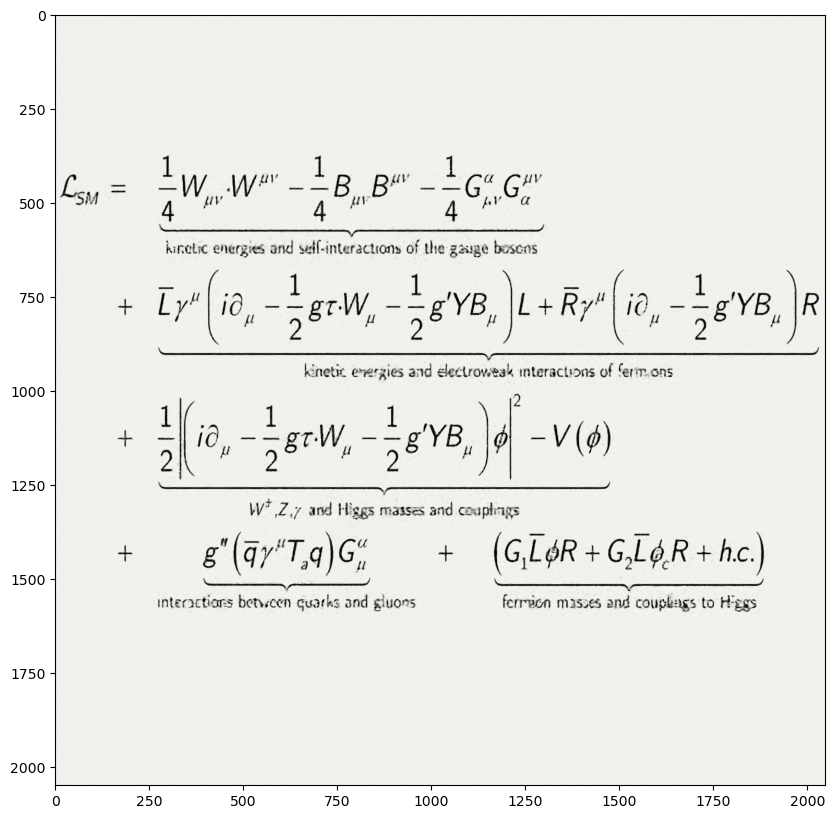

In [154]:
#plot the reconstructed image
Nrecon = 2048
x = torch.linspace(0, 1, Nrecon, device=cuda)
y = torch.linspace(0, 1, Nrecon, device=cuda)
x, y = torch.meshgrid(x, y)
p = torch.stack((x, y), dim=2).view(-1, 2)
reconstructed_im = model(p).view(Nrecon, Nrecon, 3).cpu().detach().numpy()

plt.figure(figsize=(10,10))
plt.imshow(reconstructed_im, cmap='gray')
plt.show()

In [144]:
#compression ratio

#size of the original image
size = target_im.shape[0]*target_im.shape[1]*target_im.shape[2]
print('size of the original image: ', size)

#size of the reconstructed image is number of parameters in the model
sizer = 0
for p in model.parameters():
    sizer += p.numel()
print('size of the reconstructed image: ', sizer)

#compression ratio
print('compression ratio: ', size/sizer)

size of the original image:  1618323
size of the reconstructed image:  66403
compression ratio:  24.371233227414425


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


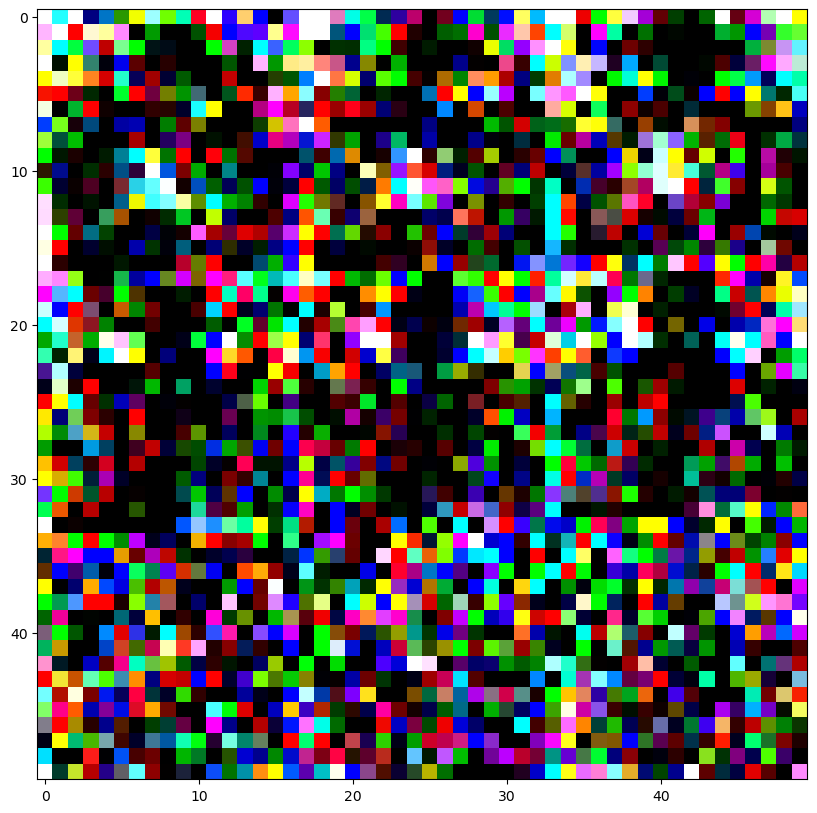

In [199]:
#plot the embeddings
plt.figure(figsize=(10,10))
rgb_embed = torch.stack((model.embed0[:,0], model.embed0[:,1], model.embed0[:,2]), dim=1).view(50, 50, 3)
plt.imshow(rgb_embed.cpu().detach().numpy())
plt.show()

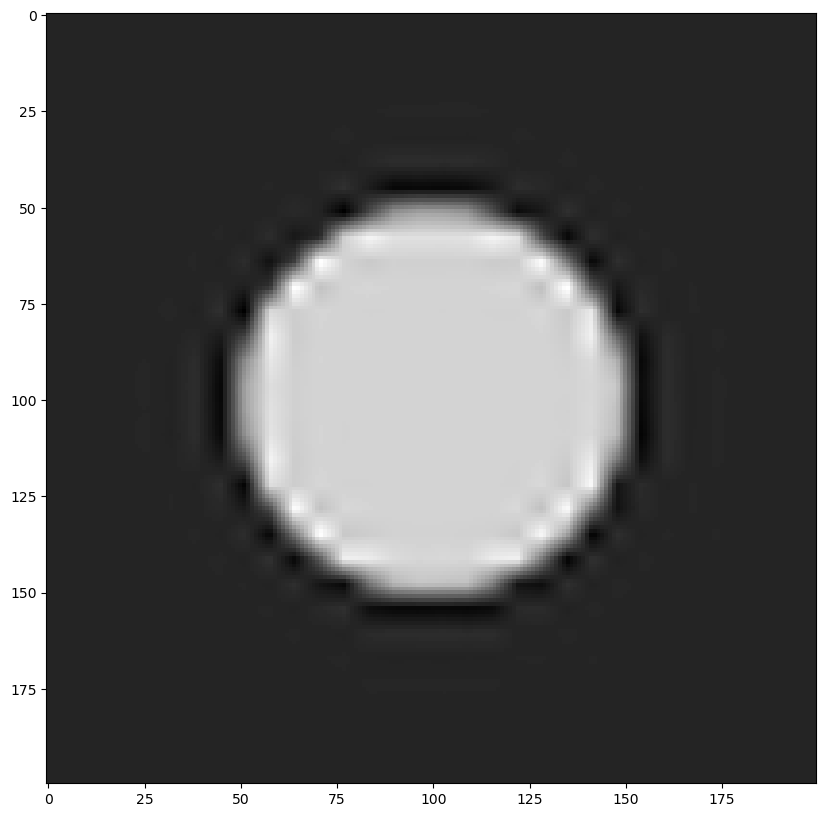

In [35]:
#interpolate the low res image to the high res image
x = torch.linspace(0, 1, Nimg, device=cuda)
y = torch.linspace(0, 1, Nimg, device=cuda)
x, y = torch.meshgrid(x, y)
p = torch.stack((x.flatten(), y.flatten()), dim=1)
train_im = bilinear(train_im, p)

plt.figure(figsize=(10,10))
plt.imshow(train_im.cpu().detach().numpy().reshape(Nimg, Nimg), cmap='gray')
plt.show()

In [90]:
import re
import numpy as np

def dump_data(dat):
  dat = dat.cpu().detach().numpy()
  return dat

def print_vec4(ws):
  vec = "vec4(" + ",".join(["{0:.3f}".format(w) for w in ws]) + ")"
  vec = re.sub(r"\b0\.", ".", vec)
  return vec

def dithered_rounding(x):
  rand = np.random.uniform(0, 1, x.shape)
  return np.floor(x + rand)

def pack_vec4_to_uint32(ws):
  ws = np.array(ws)
  ws = np.clip(ws, 0, 1)
  ws = dithered_rounding(ws*255)
  ws = ws.astype(np.uint32)
  return ws[0] + ws[1]*256 + ws[2]*256*256 + ws[3]*256*256*256

def print_uvec4(ws):
  vec = "uvec4(" + ",".join(["{0:d}".format(w) for w in ws]) + ")"
  return vec

def print_mat4(ws):
  mat = "mat4(" + ",".join(["{0:.3f}".format(w) for w in np.transpose(ws).flatten()]) + ")"
  mat = re.sub(r"\b0\.", ".", mat)
  return mat

def serialize_to_shadertoy(siren, varname):
  #first layer
  output = ""
  chunks = int(siren.Nin/4)
  lin = siren.nn[0]
  in_w = dump_data(lin.weight)
  in_bias = dump_data(lin.bias)
  hidden_layers = len(siren.nn) - 1
  residualNetwork = False
  om = 1

  #hidden layers
  for layer in range(hidden_layers):
    output += "//layer %d \n"%(layer+1)
    layer_w = dump_data(siren.nn[layer].weight)
    layer_bias = dump_data(siren.nn[layer].bias)
    for row in range(chunks):
      line = ("vec4 %s%d_%d" % (varname, layer+1, row)) + "=sin(" + (str(siren.omega) if layer==0 else "1.0") + " * ("
      for col in range(chunks):
        mat = layer_w[row*4:(row+1)*4,col*4:(col+1)*4]
        line += print_mat4(mat) + ("*%s%d_%d"%(varname, layer, col)) + "+\n    "
      bias = layer_bias[row*4:(row+1)*4]
      line += print_vec4(bias)+"))" + ("+%s%d_%d;"%(varname, layer, row) if residualNetwork else ";")
      output += line + '\n'
    output += '\n'

  #output layer
  output += "//output layer \n"
  out_w = dump_data(siren.nn[-1].weight)
  out_bias = dump_data(siren.nn[-1].bias)
  for outf in range(siren.Nout):
    line = "float %s_%d=" % (varname, outf)
    for row in range(chunks):
      vec = out_w[outf,row*4:(row+1)*4]
      line += ("dot(%s%d_%d,"%(varname, hidden_layers, row)) + print_vec4(vec) + ")+\n    "
    output += line + "{:0.3f}".format(out_bias[outf])+";" + '\n'

  return output


# output the model as glsl code
def output_glsl(model, name):
    with open(name, 'w') as f:
        #write the embedding textures as arrays
        def write_embed(embed, name = 'embed'):
            f.write('const vec4 ' + name + '[{}] = vec4[]('.format(embed.shape[1]*embed.shape[2]*embed.shape[3]//4))
            for i in range(embed.shape[2]):
                for j in range(embed.shape[3]):
                    for k in range(embed.shape[1]//4):
                        f.write(print_vec4(embed[0,k*4:(k+1)*4,i,j]))
                        if i == embed.shape[2]-1 and j == embed.shape[3]-1 and k == embed.shape[1]//4-1:
                            f.write(');')
                        else:
                            f.write(',')
        
        def write_embed_quant(embed, name = 'embed'):
          #normalize the embedding
          emb_min = embed.min()
          emb_max = embed.max()
          embed = (embed - emb_min) / (emb_max - emb_min)
          #write the min and max
          f.write('const float {}_min = {}; \n'.format(name, emb_min))
          f.write('const float {}_max = {}; \n'.format(name, emb_max))
          #write the quantized embedding
          f.write('const uvec4 ' + name + '[{}] = uvec4[]('.format(embed.shape[1]*embed.shape[2]*embed.shape[3]//16))
          for i in range(embed.shape[2]):
              for j in range(embed.shape[3]//4):
                  for k in range(embed.shape[1]//4):
                      f.write(print_uvec4([pack_vec4_to_uint32(embed[0,k*4:(k+1)*4,i,j*4+l]) for l in range(4)]))
                      if i == embed.shape[2]-1 and j == embed.shape[3]//4-1 and k == embed.shape[1]//4-1:
                          f.write(');')
                      else:
                          f.write(',')

        #write_embed(model.embed0.cpu().detach().numpy(), 'embed0')
        #f.write('\n')
        #write_embed(model.embed1.cpu().detach().numpy(), 'embed1')
        #f.write('\n')
        #write_embed(model.embed2.cpu().detach().numpy(), 'embed2')
        #f.write('\n')
        #write_embed(model.embed3.cpu().detach().numpy(), 'embed3')
        #f.write('\n')

        write_embed_quant(model.embed0.cpu().detach().numpy(), 'embed0_quant')
        f.write('\n')
        write_embed_quant(model.embed1.cpu().detach().numpy(), 'embed1_quant')
        f.write('\n')
        write_embed_quant(model.embed2.cpu().detach().numpy(), 'embed2_quant')
        f.write('\n')
        write_embed_quant(model.embed3.cpu().detach().numpy(), 'embed3_quant')
        f.write('\n')

        #write embed texture size
        f.write('const int embed_texture = {}; \n'.format(model.embed0.shape[2]))
        f.write('const int embed_channels = {}; \n'.format(model.embed0.shape[1]))

        #write the model as a function
        vec4chunks = int(4*model.embed0.shape[1]/4)

        f.write('vec3 model(');
        for i in range(vec4chunks):
            f.write('vec4 e0_{} '.format(i))
            if i != vec4chunks-1:
                f.write(',')
        f.write('){\n')

        #write the model as a function
        f.write(serialize_to_shadertoy(model, 'e'))

        #write the output
        f.write('return vec3(e_0, e_1, e_2);} \n')


        
        
            



In [155]:
output_glsl(model, 'reconstruction.glsl')